## Importowanie odpowiednich bibliotek

In [225]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import copy
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier
from scipy.stats import f_oneway
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import shap

# import warnings
# warnings.filterwarnings("ignore")

## Ustawienie stałych

In [226]:
DATASET_NAME = 'zbiór_15.csv'
TARGET_COLUMN = 'default'
RANDOM_STATE = 4
IV_DROP_THRESHOLD = 0.3
CORRELATION_DROP_THRESHOLD = 0.95
TEST_SIZE = 0.2
RANDOM_FORREST_N_ESTIMATORS = 300
WOE_BINS = 20

## Wczytanie danych i wstępna analiza

In [227]:
data = pd.read_csv(DATASET_NAME)
data.head()

,szczegolnaFormaPrawna_Symbol,formaWlasnosci_Symbol,pkdKod,wsk_liczba_dni_istnienia,Aktywa,Aktywa_trwale,Wartosci_niematerialne_prawne,Wartosc_firmy,Rzeczowe_aktywa_trwale,Srodki_trwale,...,wsk_struktura_kap_wlasnego_s_1,wsk_struktura_kap_wlasnego_s_2,wsk_zadluzenia,wsk_zob_dlugoterminowe_aktywa_rzeczowe,wsk_zob_oprocentowanych,wsk_zob_oprocentowanych_aktywa_rzeczowe,wsk_struktura_kap_obcego_s,wsk_zob_s_aktywa_rzeczowe,wsk_fin_majatku_kapitalem,default
0,117,214,6201,8993,112709.98,0.00,0.0,0.0,0.00,0.00,...,0.950530,0.950530,0.052044,0.000000,0.000000,0.000000,0.049470,0.049470,0.950530,1
1,117,214,4110,2607,2369051.57,5063.80,0.0,0.0,5063.80,5063.80,...,0.264511,0.271964,2.780566,0.000000,0.444723,0.444723,0.735489,0.708082,0.262935,1
2,117,215,7022,5868,71925.97,0.00,0.0,0.0,0.00,0.00,...,0.944960,0.944960,0.058246,0.055040,0.000000,0.000000,0.055040,0.055040,0.944960,1
3,117,214,6920,1668,12247.82,0.00,0.0,0.0,0.00,0.00,...,0.774826,0.774826,0.290612,0.225174,0.000000,0.000000,0.225174,0.225174,0.774826,1
4,117,214,6619,1994,614984.31,131077.01,0.0,0.0,118777.01,118777.01,...,0.394975,1.251990,1.531805,0.206732,0.371039,0.371039,0.605025,-0.079497,0.231091,1


In [228]:
data.describe()

invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in reduce


,szczegolnaFormaPrawna_Symbol,formaWlasnosci_Symbol,pkdKod,wsk_liczba_dni_istnienia,Aktywa,Aktywa_trwale,Wartosci_niematerialne_prawne,Wartosc_firmy,Rzeczowe_aktywa_trwale,Srodki_trwale,...,wsk_struktura_kap_wlasnego_s_1,wsk_struktura_kap_wlasnego_s_2,wsk_zadluzenia,wsk_zob_dlugoterminowe_aktywa_rzeczowe,wsk_zob_oprocentowanych,wsk_zob_oprocentowanych_aktywa_rzeczowe,wsk_struktura_kap_obcego_s,wsk_zob_s_aktywa_rzeczowe,wsk_fin_majatku_kapitalem,default
count,3000.0,3000.000000,3000.000000,3000.000000,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,...,3000.000000,2957.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,117.0,200.979667,5344.899000,4043.084000,7.736907e+06,5.146257e+06,4.285282e+04,4.747901e+03,1.131901e+06,1.011080e+06,...,5.092878,NaN,14.869922,1.892967,1.938928,1.940652,14.663446,9.615697,-6.743099,0.053000
std,0.0,51.816209,1962.118082,2794.093839,9.986779e+07,8.898365e+07,9.220774e+05,9.643449e+04,5.362261e+06,5.018179e+06,...,119.399309,NaN,392.698022,58.012314,59.058917,59.058880,497.022096,373.166334,681.316755,0.224071
min,117.0,0.000000,0.000000,1204.000000,0.000000e+00,0.000000e+00,-5.800000e-01,0.000000e+00,0.000000e+00,-8.739250e+03,...,-939.811838,-inf,-1.351786,-16.265592,-17.825569,-17.825569,-180.575028,-1844.269400,-32062.387100,0.000000
25%,117.0,214.000000,4321.000000,1805.750000,8.797910e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.348431,0.412853,0.074446,0.000000,0.000000,0.000000,0.069078,-0.066635,0.081244,0.000000
50%,117.0,214.000000,4941.000000,3009.000000,5.992333e+05,2.230695e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.658558,0.794606,0.447030,0.000000,0.000000,0.000000,0.309920,0.135711,0.508948,0.000000
75%,117.0,215.000000,6920.000000,5636.750000,2.709980e+06,5.616736e+05,0.000000e+00,0.000000e+00,1.350023e+05,1.024320e+05,...,0.904009,1.063178,1.537708,0.190159,0.102220,0.103234,0.612969,0.490105,0.857255,0.000000
max,117.0,338.000000,9609.000000,16617.000000,4.532282e+09,4.531929e+09,4.860000e+07,3.933141e+06,1.202187e+08,1.191571e+08,...,4300.000000,inf,20866.570800,2638.471300,2557.170400,2557.170400,24378.434200,16593.611300,15211.326300,1.000000


In [229]:
print("Default count: " + str(data[TARGET_COLUMN].value_counts()[1]))
print("No default count: " + str(data[TARGET_COLUMN].value_counts()[0]))

Default count: 159
No default count: 2841


## Podział kolumn na zmienne kategoryczne i liczbowe

Do dalszej analizy definiujemy zbiory kolumn kategorycznych i liczbowych.

In [230]:
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object']).columns
print(categorical_features)

Index(['schemat_wsk_bilans', 'schemat_wsk_rzis'], dtype='object')


In [231]:
data[categorical_features].head(10)

,schemat_wsk_bilans,schemat_wsk_rzis
0,SFJIN,SFJIN
1,SFJMA,SFJMA
2,SFJMI,SFJMI
3,SFJMI,SFJMI
4,SFJMA,SFJMA
5,SFJIN,SFJIN
6,SFJIN,SFJIN
7,SFJMA,SFJMA
8,SFJIN,SFJIN
9,SFJIN,SFJIN


## Zamiana zmiennych kategorycznych

Zmienne kategoryczne zostały przekształcone z użyciem techniki "one hot encoding", która pozwala zamienić je na kilka zmiennych binarnych.

In [232]:
one_hot_encoded = pd.get_dummies(data[categorical_features])
data = pd.concat([data, one_hot_encoded], axis=1)
data = data.drop(categorical_features, axis=1)

## Zamiana brakujących wartości

Brakujące wartości są przedstawione w ramce danych `data` jako wartości `NaN`. Zostały one zamienione z użyciem mediany w danej kolumnie.

In [233]:
data = data.fillna(data.median())
data.describe()

invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in reduce


,szczegolnaFormaPrawna_Symbol,formaWlasnosci_Symbol,pkdKod,wsk_liczba_dni_istnienia,Aktywa,Aktywa_trwale,Wartosci_niematerialne_prawne,Wartosc_firmy,Rzeczowe_aktywa_trwale,Srodki_trwale,...,wsk_struktura_kap_wlasnego_s_1,wsk_struktura_kap_wlasnego_s_2,wsk_zadluzenia,wsk_zob_dlugoterminowe_aktywa_rzeczowe,wsk_zob_oprocentowanych,wsk_zob_oprocentowanych_aktywa_rzeczowe,wsk_struktura_kap_obcego_s,wsk_zob_s_aktywa_rzeczowe,wsk_fin_majatku_kapitalem,default
count,3000.0,3000.000000,3000.000000,3000.000000,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,117.0,200.979667,5344.899000,4043.084000,7.736907e+06,5.146257e+06,4.285282e+04,4.747901e+03,1.131901e+06,1.011080e+06,...,5.092878,NaN,14.869922,1.892967,1.938928,1.940652,14.663446,9.615697,-6.743099,0.053000
std,0.0,51.816209,1962.118082,2794.093839,9.986779e+07,8.898365e+07,9.220774e+05,9.643449e+04,5.362261e+06,5.018179e+06,...,119.399309,NaN,392.698022,58.012314,59.058917,59.058880,497.022096,373.166334,681.316755,0.224071
min,117.0,0.000000,0.000000,1204.000000,0.000000e+00,0.000000e+00,-5.800000e-01,0.000000e+00,0.000000e+00,-8.739250e+03,...,-939.811838,-inf,-1.351786,-16.265592,-17.825569,-17.825569,-180.575028,-1844.269400,-32062.387100,0.000000
25%,117.0,214.000000,4321.000000,1805.750000,8.797910e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.348431,0.419260,0.074446,0.000000,0.000000,0.000000,0.069078,-0.066635,0.081244,0.000000
50%,117.0,214.000000,4941.000000,3009.000000,5.992333e+05,2.230695e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.658558,0.794606,0.447030,0.000000,0.000000,0.000000,0.309920,0.135711,0.508948,0.000000
75%,117.0,215.000000,6920.000000,5636.750000,2.709980e+06,5.616736e+05,0.000000e+00,0.000000e+00,1.350023e+05,1.024320e+05,...,0.904009,1.050612,1.537708,0.190159,0.102220,0.103234,0.612969,0.490105,0.857255,0.000000
max,117.0,338.000000,9609.000000,16617.000000,4.532282e+09,4.531929e+09,4.860000e+07,3.933141e+06,1.202187e+08,1.191571e+08,...,4300.000000,inf,20866.570800,2638.471300,2557.170400,2557.170400,24378.434200,16593.611300,15211.326300,1.000000


## Zamiana nieskończoności

W zbiorze danych występowały wartości nieskończone, które muszą być usunięte przed dalszą analizą. Zostały one zastąpione wartością minimalną (w przypadku `-Inf`) lub maksymalną (w przypadku `Inf`) w każdej kolumnie.

In [234]:
missing_columns = ['wsk_plynnosc_biez_1', 'wsk_struktura_kap_wlasnego_s_2', 'wsk_kapital_do_aktywa']

# Replace 'inf' with maximum value and '-inf' with minimum value in each column
for column in missing_columns:
    max_value = data[column].replace([np.inf, -np.inf], np.nan).max()
    min_value = data[column].replace([np.inf, -np.inf], np.nan).min()
    data[column].replace([np.inf, -np.inf], np.nan, inplace=True)
    data[column].fillna(max_value, inplace=True)  # Replace 'inf' with max
    data[column].replace(-np.inf, min_value, inplace=True)  # Replace '-inf' with min

## Usunięcie wartości odstających

Następnym krokiem jest usunięcie wartości odstających w każdej kolumnie. Dla każdej kolumny o typie numerycznym obliczane są granice przedziałów, w którym znajdować się mają wartości, na podstawie dolnego i górnego kwartylu oraz rozstępu międzykwartylowego. Po obliczneniu tych wartości, każda wartość w kolumnie jest obcinana tak, aby nie wychodziła poza granice przedziału.

In [235]:
def remove_columns(data, columns_to_remove):
    print(f"Number of colums before removal: {data.shape[1]}")
    data.drop(columns=columns_to_remove, inplace=True)
    print(f"Number of colums after removal: {data.shape[1]}")
    
    return data.select_dtypes(include=['int64', 'float64']).columns

In [236]:
def outlier_bounds(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

for column in data[numeric_features].drop([TARGET_COLUMN], axis=1).columns:
    lower, upper = outlier_bounds(data[column])
    data[column] = data[column].clip(lower, upper)

## Usunięcie kolumn z zerową wariancją

Usuwamy kolumny z zerową wariancją, to jest takie, których wartości są zawsze takie same. Kolumny te nie wnoszą żadnej informacji przy budowie modeli uczenia maszynowego na zbiorze danych.

In [237]:
variance = data[numeric_features].var()
numeric_features = remove_columns(data, variance[variance == 0].index)

Number of colums before removal: 224
Number of colums after removal: 172


## Usunięcie kolumn zgodnie z testem ANOVA

Następnym krokiem jest sprawdzenie, jak silnie każda kolumna jest powiązana z kolumną ze zmienną celu `default`. W tym celu skorzystaliśmy z testu ANOVA. Dla każdej kolumny otrzymujemy tak zwane `p-value`. Jeśli wartość ta jest poniżej pewnej wartości (zwykle `0.05`) to oznacza to, że jest istotnie powiązana ze zmienną celu. W przeciwnym wypadku usuwamy ją ze zbioru danych.

In [238]:
columns_to_remove = []
for column in data[numeric_features].columns:
    if column != 'default':
        group1 = data[data['default'] == 0][column]
        group2 = data[data['default'] == 1][column]

        _, p_value = f_oneway(group1, group2)

        if p_value > 0.05:
            columns_to_remove.append(column)

numeric_features = remove_columns(data, columns_to_remove)

Each of the input arrays is constant;the F statistic is not defined or infinite


Number of colums before removal: 172
Number of colums after removal: 133


## Wykorzystanie techniki Weight of Evidence oraz Information Value

Technika WoE (Weight of Evidence) jest stosowana głównie w modelowaniu kredytowym i finansowym, która polega na przekształcaniu zmiennych kategorycznych lub dyskretnych w ciągłe. W naszym przypadku, zmienne numeryczne zostały podzielone na różne zakresy, a dla każdego z tych zakresów obliczono WOE, który mierzy, jak mocno dany zakres różni się od pozostałych pod względem predykcji wyniku. 

IV (Information Value) to miara używana do określenia siły predykcyjnej całej zmiennej, bazująca na obliczonym WOE. Wyższa wartość IV oznacza, że zmienna ma większe znaczenie predykcyjne.

Usunięte zostały kolumny, które miały niską wartość IV, co oznacza, że ich zdolność do przewidywania wyniku jest ograniczona. Pozostawienie jedynie zmiennych o wysokiej wartości IV pozwala na zbudowanie bardziej efektywnego i skoncentrowanego modelu.

In [239]:
def calculate_woe_iv(data, variable, target):
    # Create bins for numerical variables
    if pd.api.types.is_numeric_dtype(data[variable]):
        bins_variable = variable + '_bins'
        data[bins_variable] = pd.qcut(data[variable], q=WOE_BINS, duplicates='drop')
        grouped = data.groupby(bins_variable)[target].agg(['count', 'sum'])
        grouped = grouped.rename(columns={'count': 'total', 'sum': 'events'})
    else:
        grouped = data.groupby(variable)[target].agg(['count', 'sum'])
        grouped = grouped.rename(columns={'count': 'total', 'sum': 'events'})

    grouped['non_events'] = grouped['total'] - grouped['events']

    eps = 1e-8  # Add a small constant to prevent divide by zero
    grouped['event_rate'] = (grouped['events'] + eps) / (grouped['events'].sum() + eps)
    grouped['non_event_rate'] = (grouped['non_events'] + eps) / (grouped['non_events'].sum() + eps)

    grouped['woe'] = np.log(grouped['event_rate'] / grouped['non_event_rate'])
    grouped['iv'] = (grouped['event_rate'] - grouped['non_event_rate']) * grouped['woe']

    iv = grouped['iv'].sum()

    return grouped, iv

data_copied = copy.deepcopy(data)
woe_iv_results = []
for column in data.columns:
    if column != TARGET_COLUMN:
        grouped_data, iv = calculate_woe_iv(data_copied, column, TARGET_COLUMN)
        woe_iv_results.append({'Variable': column, 'IV': iv})

# Sort the results by IV in descending order
woe_iv_results = sorted(woe_iv_results, key=lambda x: x['IV'])

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed

### Wykres Information Value dla każdej zmiennej

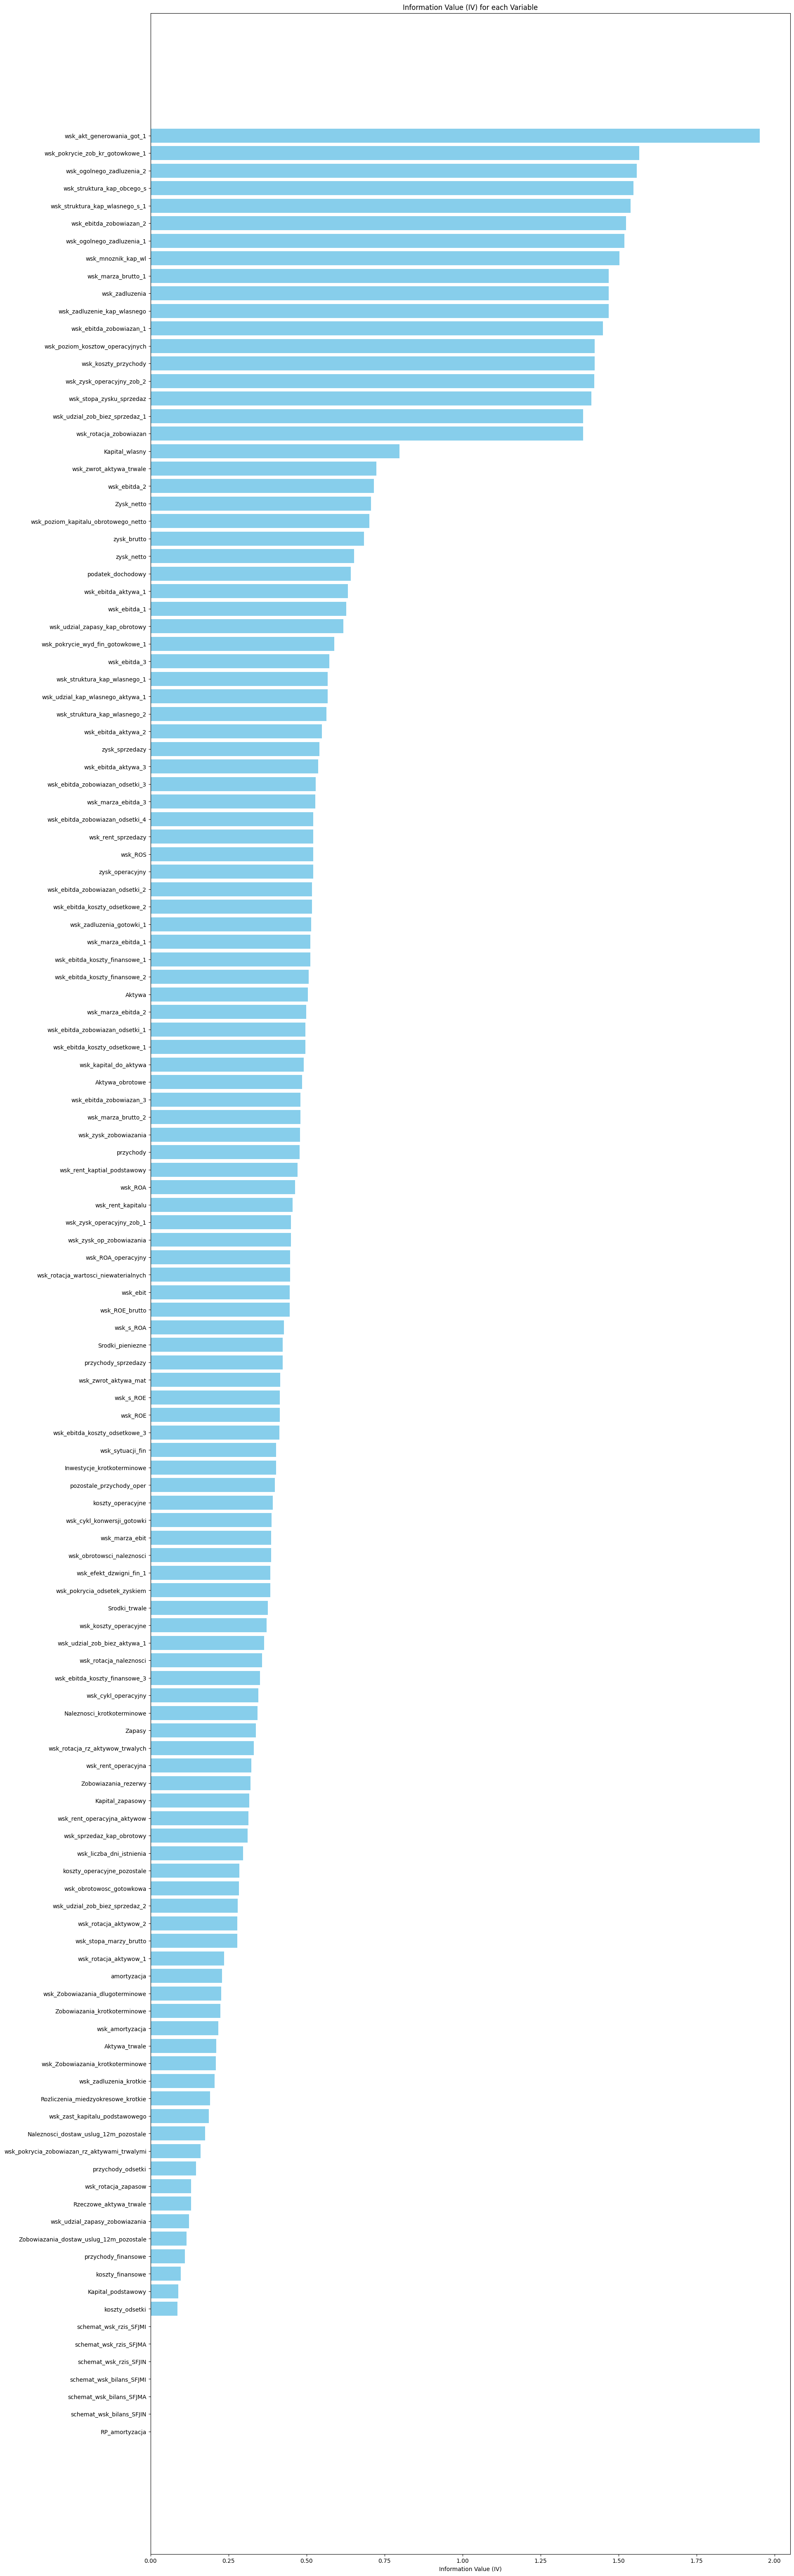

In [240]:
variables = [result['Variable'] for result in woe_iv_results]
iv_values = [result['IV'] for result in woe_iv_results]

# Create a bar plot
plt.figure(figsize=(20, 80))
plt.barh(variables, iv_values, color='skyblue')
plt.xlabel('Information Value (IV)')
plt.title('Information Value (IV) for each Variable')
plt.show()

### Usuwanie kolumn o niskim Information Value

In [241]:
print("Number of colums before: " + str(len(data.columns)))
low_iv_columns = [result['Variable'] for result in woe_iv_results if result['IV'] < IV_DROP_THRESHOLD]
data.drop(low_iv_columns, axis=1, inplace=True)
print("Number of colums after: " + str(len(data.columns)))

Number of colums before: 133
Number of colums after: 99


## Analiza korelacji

Ostatnim krokiem przed budową modeli będzie analiza korelacji wszystkich zmiennych. W celu jej wizualizacji poniżej znajduje się macierz korelacji, w której silnie czerwony lub silnie niebieski kolor informuje o wysokiej korelacji zmiennych. Następnie usuwamy zmienne o wysokiej korelacji z inną zmienną (powyżej 95%) i pozostawiamy zmienną z najwyższą wartością IV.

### Wyświetlenie macierzy korelacji

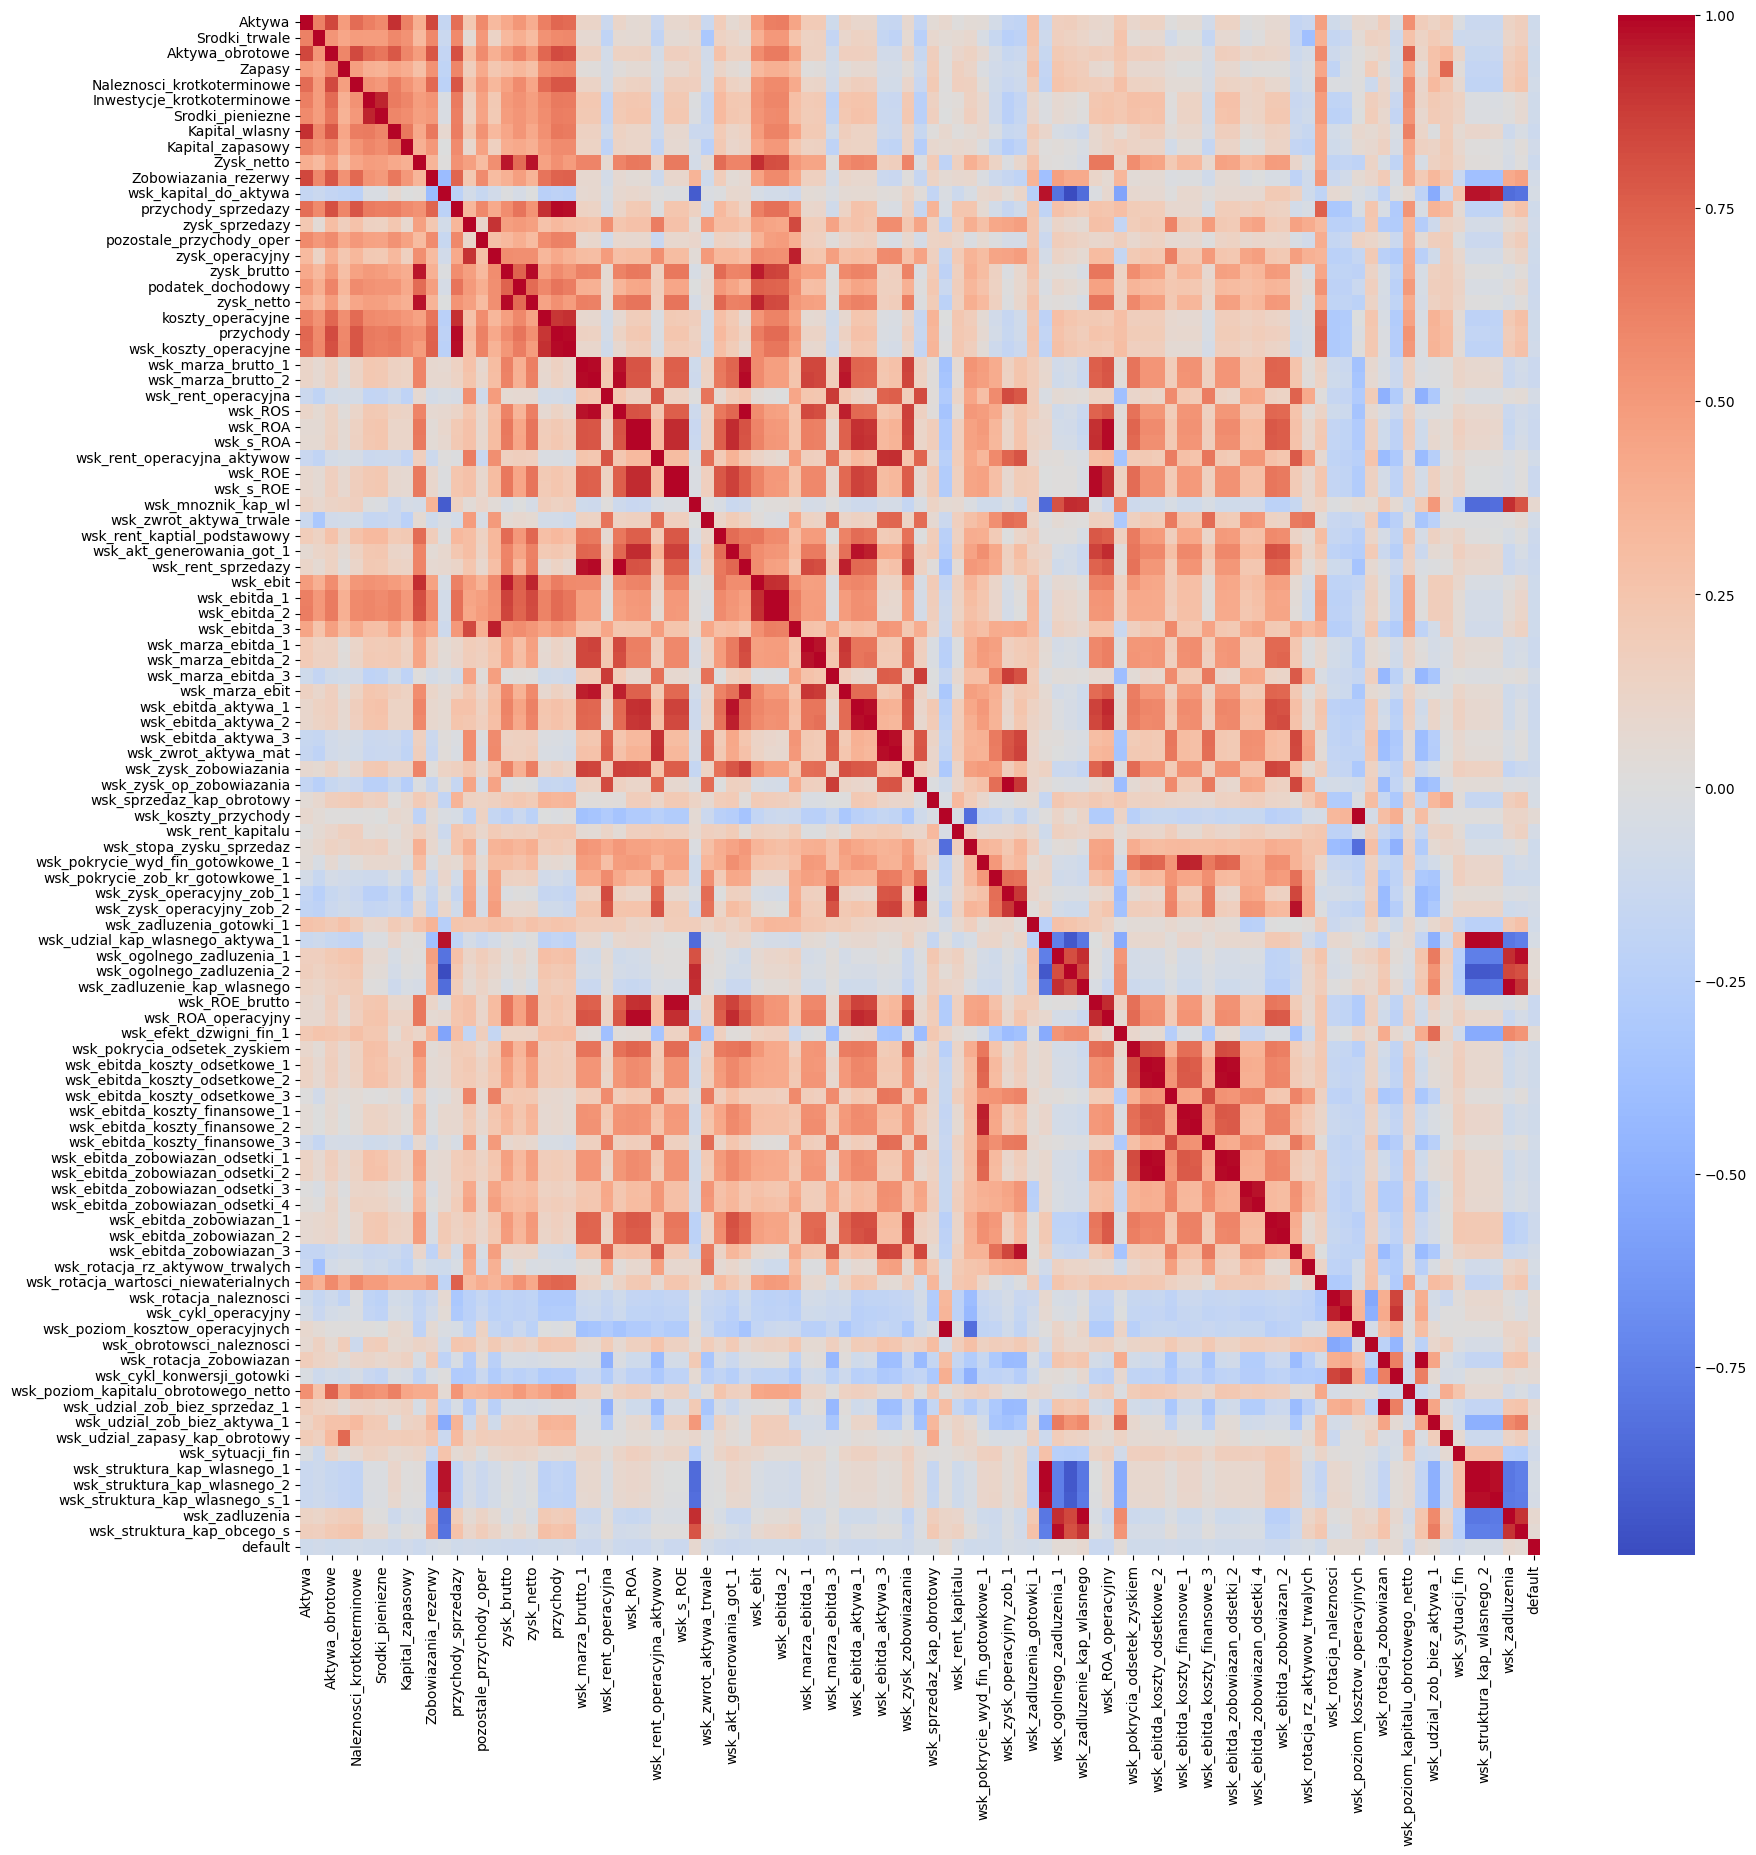

In [242]:
correlation_matrix = data.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.2f')
plt.show()

### Usunięcie wysoko skorelowanych zmiennych

In [243]:
print("Number of colums before: " + str(len(data.columns)))

highly_correlated_pairs = []
columns_to_remove = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > CORRELATION_DROP_THRESHOLD:
            pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
            highly_correlated_pairs.append(pair)

# Keep variables with higher IV in each pair
for pair in highly_correlated_pairs:
    var1, var2 = pair
    iv_var1 = next(item['IV'] for item in woe_iv_results if item['Variable'] == var1)
    iv_var2 = next(item['IV'] for item in woe_iv_results if item['Variable'] == var2)
    
    if var2 in data.columns and var1 in data.columns:
        if iv_var1 > iv_var2:
            # Keep var1, remove var2
            data = data.drop(var2, axis=1)
        else:
            # Keep var2, remove var1
            data = data.drop(var1, axis=1)

print("Number of colums after: " + str(len(data.columns)))

Number of colums before: 99
Number of colums after: 67


## Metody pomocnicze w ocenie jakości modeli

Poniżej zdefiniowaliśmy kilka metod pomocniczych, których używamy w ocenie modeli.

### Współczynniki AUC i Giniego

Współczynniki AUC (Area under Curve) i Giniego to metryki służące do oceny wydajności modeli klasyfikacyjnych. Współczynnik AUC odnosi się do pola pod krzywą ROC (Receiver Operating Characteristic), która reprezentuje zdolności modelu do rozróżniania między klasami. Współczynnik Giniego jest miarą nierówności i definiowany jest jako

$$ Gini = 2 \times AUC - 1 $$

In [244]:
def calculate_auc_gini(y_test, y_pred_prob):
    auc = roc_auc_score(y_test, y_pred_prob)
    gini = 2 * auc - 1

    return auc, gini

### Wskaźniki Accuracy, Precision, Recall i F1

Wskaźniki accuracy, precision, recall i F1 są powszechnie używanymi wskaźnikami do oceny klasyfikatorów. Poniższa metoda oblicza je na podstawie wytrenowanego modelu i danych testowych, używając do tego bibliotecznej funkcji `classification_report`.

In [245]:
def test_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    auc, gini = calculate_auc_gini(y_test, model.predict_proba(X_test)[:, 1])
    report = classification_report(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')
    print(f'AUC: {auc:.2f}')
    print(f'Gini: {gini:.2f}')
    print(report)

## Podział zbioru na zbiór treningowy i testowy

Podział zbioru na zbiór treningowy i testowy wykonujemy z użyciem bibliotecznej funkcji `train_test_split`. Dzieli ona wejściowy zbiór danych na dwa zbiory o liczności zdefiniowanej na wejściu. W naszym przypadku proporcja liczności zbioru treningowego do testowego to 80/20. Ważnym aspektem jest stratyfikacja, czyli zapewnienie, że w zbiorze treningowym i testowym prawdopodobieństwo wartości `True` w kolumnie zmiennej celu jest takie samo.

In [246]:
features = data.drop(TARGET_COLUMN, axis=1)
target = data[TARGET_COLUMN]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=TEST_SIZE, stratify=target, random_state=RANDOM_STATE)

## Model lasu losowego

Las losowy to algorytm uczenia maszynowego, który wykorzystuje zespół drzew decyzyjnych do generowania prognoz. Każde drzewo w lesie dokonuje indywidualnej predykcji, a wynik lasu losowego jest średnią lub najczęściej występującą predykcją wszystkich drzew. Poniżej zastosowaliśmy model lasu losowego z biblioteki `scikit-learn` w celu klasyfikacji na utworzonych zbiorach.

In [247]:
model = RandomForestClassifier(n_estimators=RANDOM_FORREST_N_ESTIMATORS, random_state=RANDOM_STATE)

# Train the model
model.fit(X_train, y_train)

# Evaluate the accuracy of the model
test_model(model, X_test, y_test)

Accuracy: 0.94
AUC: 0.71
Gini: 0.43
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       568
           1       0.00      0.00      0.00        32

    accuracy                           0.94       600
   macro avg       0.47      0.50      0.49       600
weighted avg       0.90      0.94      0.92       600



Nasz model uzyskał dobre wyniki. Współczynnik dokładności (accuracy) jest na wysokim poziomie `0.94`. Z uwagi na to, że próbka jest niezbilansowana pod względem zmiennej celu `default`, nie należy kierować się miarami oceny klasyfikatora, takimi jak precision, recall i F1. W zamian tego możemy spojrzeć na współczynniki AUC i Giniego.

### Walidacja krzyżowa

Walidacja krzyżowa to technika stosowana przy budowie modeli uczenia maszynowego, która zapewnia jego stabilność i wiarygodność. Poniżej wykorzystaliśmy funkcję biblioteczną `cross_validate` z biblioteki `scikit-learn`, wykorzystująć metodę K-Fold. Wybierany jest najlepszy estymator pod względem współczynnika Giniego otrzymanego na zbiorze testowym.

In [248]:
model = RandomForestClassifier(n_estimators=RANDOM_FORREST_N_ESTIMATORS, random_state=RANDOM_STATE)

scores = cross_validate(model, X_train, y_train, cv=10, scoring='roc_auc', return_estimator=True, n_jobs=-1)

max_gini = -np.inf
best_estimator = model
for estimator in scores['estimator']:
    _, gini = calculate_auc_gini(y_test, estimator.predict_proba(X_test)[:, 1])
    if gini > max_gini:
        best_estimator = estimator
        max_gini = gini

test_model(best_estimator, X_test, y_test)

Accuracy: 0.95
AUC: 0.73
Gini: 0.45
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       568
           1       1.00      0.03      0.06        32

    accuracy                           0.95       600
   macro avg       0.97      0.52      0.52       600
weighted avg       0.95      0.95      0.92       600



### Ważności cech

Poniżej znajduje się wizualizacja ważności cech dla najlepszego modelu lasu losowego po walidacji krzyżowej.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



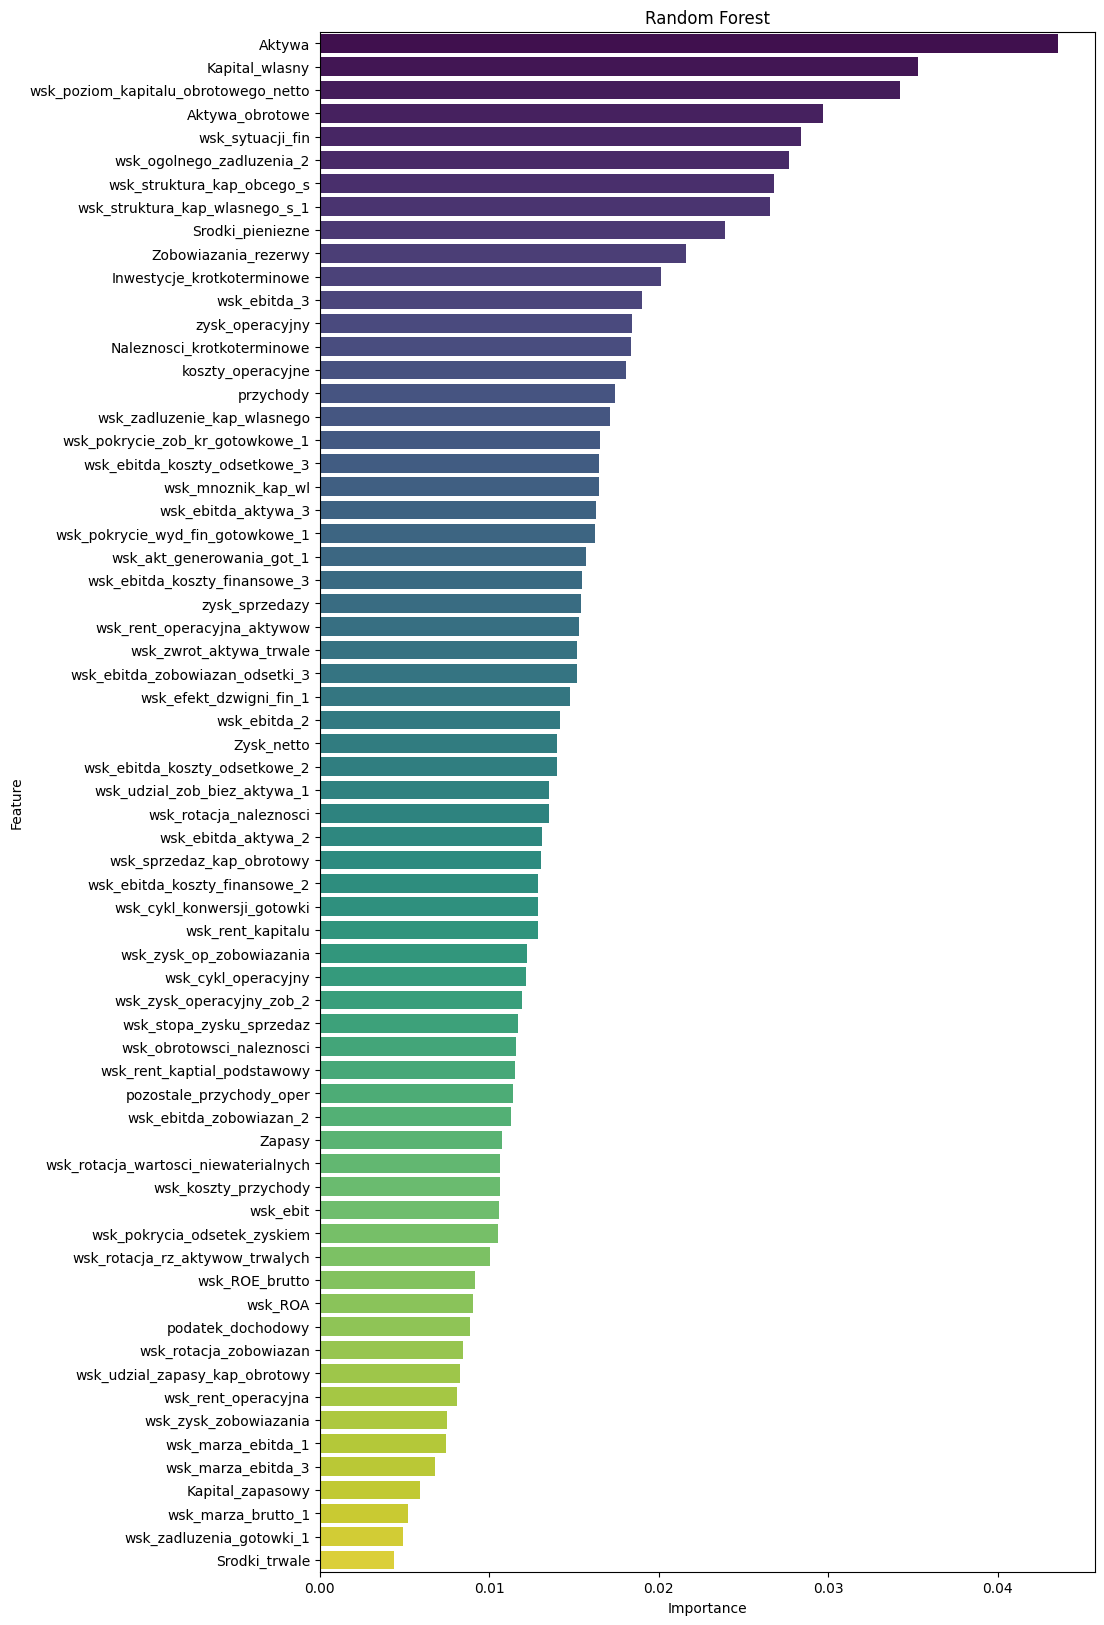

In [249]:
feature_importances = best_estimator.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 20))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title("Random Forest")
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Jak widać na powyższym wykresie, model najbardziej kieruje się zmiennymi `Aktywa` oraz `Kapital_wlasny` przy podejmowaniu decyzji. Ważną rolę pełnią także wskaźniki finansowe, takie jak `wsk_poziom_kapitalu_obrotowego_netto`.

### Kalibracja modelu

Końcowym etapem pracy z modelem lasu losowego jest jego kalibracja. Do tego celu wykorzystamy klasę `CalibratedClassifierCV` z biblioteki `scikit-learn`. Kalibracja wykonywana jest po to, aby dostosować prognozy modelu do rzeczywistej tendencji w danych.

In [250]:
calibrated_model = CalibratedClassifierCV(best_estimator, method='sigmoid')

calibrated_model.fit(X_train, y_train)

test_model(calibrated_model, X_test, y_test)

Accuracy: 0.94
AUC: 0.70
Gini: 0.41
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       568
           1       0.00      0.00      0.00        32

    accuracy                           0.94       600
   macro avg       0.47      0.50      0.49       600
weighted avg       0.90      0.94      0.92       600



Jak widać, kalibracja modelu poprawiła nieco współczynnik Giniego badanego modelu.

## Model XGBoost

Drugim modelem, jaki użyjemy do klasyfikacji, jest XGBoost (eXtreme Gradient Boosting). Jest to algorytm uczenia maszynowego, który korzysta z techniki wzmacniania gradientowego do optymalizacji modeli predykcyjnych. Przed wykorzystaniem tego modelu przeprowadzimy analizę PCA.

### Standardyzacja danych

Przed przeprowadzeniem analizy PCA dane należy ustandaryzować.

In [251]:
names = list(features.columns)
features[names] = StandardScaler().fit_transform(features[names])

### Analiza PCA

PCA to technika statystyczna używana do uproszczenia złożoności danych. Pozwala ona na redukcję liczby zmiennych w zestawie danych, zachowując przy tym jak najwięcej informacji. Do wykonania tej analizy użyliśmy biblioteki `scikit-learn`.

In [252]:
pca = PCA(n_components=len(names))
data_transformed = pca.fit_transform(features)

pca_dict = {
    'Proportion of Variance': pca.explained_variance_ratio_,
    'Cumulative Proportion': np.cumsum(pca.explained_variance_ratio_)
}

n_components = pca.components_.shape[1]
pca_cols = [f'PC{x}' for x in range(n_components)]

df_transformed = pd.DataFrame(
    data = data_transformed,
    columns = pca_cols[:len(names)]
) 

# summary
df_pca_summarize = pd.DataFrame.from_dict(
    data = pca_dict,
    columns = pca_cols[:len(names)],
    orient='index'
)

print(pca.explained_variance_ratio_)

[2.47898909e-01 1.72993265e-01 9.98371857e-02 7.40325620e-02
 5.14862655e-02 3.32475745e-02 2.79338453e-02 2.26913168e-02
 2.14566637e-02 1.90755061e-02 1.52963489e-02 1.41933916e-02
 1.34948277e-02 1.25764449e-02 1.16306419e-02 1.11318513e-02
 9.93889059e-03 9.43668586e-03 8.71025447e-03 7.95287043e-03
 7.26020736e-03 6.97544694e-03 6.59509293e-03 6.33247458e-03
 5.76988000e-03 5.48161822e-03 5.34190629e-03 4.92351478e-03
 4.68183897e-03 4.23510227e-03 3.95826722e-03 3.72305146e-03
 3.66920317e-03 3.32665976e-03 3.22072556e-03 2.98125746e-03
 2.84452962e-03 2.76361663e-03 2.61496436e-03 2.39381004e-03
 2.27903063e-03 2.01755658e-03 1.79727783e-03 1.69973777e-03
 1.66755931e-03 1.48228197e-03 1.35225658e-03 1.26565818e-03
 1.13978847e-03 1.12309545e-03 1.08253003e-03 9.52084547e-04
 9.12195001e-04 8.90618548e-04 8.18288464e-04 7.81259516e-04
 7.34340139e-04 6.68314546e-04 5.77416676e-04 5.29820892e-04
 4.74586731e-04 4.24833681e-04 4.18283990e-04 3.47576261e-04
 2.41818601e-04 2.133207

### Wybór zmiennych

Wybór zmiennych po analizie PCA wykonamy wykorzystując kryterium części wyjaśnionej wariancji z ustawionym kryterium na wartość `0.9`.

In [253]:
criterium = 0.9

for c in df_pca_summarize.columns:
    if df_pca_summarize.loc['Cumulative Proportion', c] >= criterium:
        print(c)
        break

PC22


W dalszej analizie wykorzystamy zatem 22 zmienne po PCA.

In [254]:
data_after_pca = df_transformed.iloc[:, :22]
data_after_pca

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
0,-1.758611,-2.402787,3.281675,0.541758,2.495716,2.097818,0.095789,-0.604823,2.369794,1.123651,...,-1.725618,-1.076147,0.311184,0.124970,1.091140,-1.384821,0.704276,-0.593040,0.615145,-0.015691
1,1.002425,3.952103,-2.047044,2.049588,-0.466921,-0.355304,-2.276582,-1.524402,1.227121,0.100994,...,0.462654,-0.963038,-1.097740,1.566400,-0.735916,-0.911523,0.139301,0.395751,0.744213,0.087998
2,-4.311891,-1.700642,1.177778,-1.566627,2.580456,0.526153,-0.730417,-0.678118,-0.761400,0.003266,...,0.262463,1.500562,-0.716393,0.231124,0.620228,-0.219485,1.195749,-0.117044,0.722562,-0.133027
3,-0.730841,-5.165655,-2.722829,-1.187853,-1.645612,-0.141173,-0.305182,-0.284535,-1.595952,0.827242,...,-0.676416,0.664939,-0.683525,-0.779079,0.463143,-0.214081,0.256898,1.359419,0.590544,0.863995
4,-0.559245,0.742941,0.434448,2.053853,-1.251408,0.350852,1.638859,0.313736,-0.053238,-0.384450,...,0.416081,0.930745,-1.774653,-0.057859,0.525174,-0.122106,-0.563231,-0.269859,0.153741,-0.348670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,-3.240619,5.090983,-3.000474,3.186174,-0.140748,-1.445306,2.894567,-0.514163,-2.346647,2.292197,...,-1.143763,-2.471313,0.559856,-0.703898,-1.075741,0.067943,1.337665,0.021506,-0.992603,-0.417460
2996,3.459720,0.837805,1.238776,-1.341809,-1.668590,-3.306085,0.225288,1.535776,0.229899,0.396858,...,-2.549267,1.795958,-0.712982,-0.226743,-0.090537,-0.599297,1.433925,-0.846209,-0.677663,-1.463095
2997,-0.926288,0.458729,1.205071,-1.035028,-2.276179,-0.728408,-0.746754,0.289055,-0.526359,1.527784,...,0.246927,-0.554211,-1.082609,-0.968084,-0.270876,-0.909157,-0.378087,-0.869448,0.711974,0.733358
2998,5.985363,4.196179,-0.906734,0.331362,-1.396466,1.325293,-3.139550,-0.436052,-0.849148,-0.991838,...,-0.020954,-0.762439,-0.172138,0.192473,0.674912,1.564468,0.410002,0.981590,-0.331362,-0.961476


### Podział zbioru na treningowy i testowy

Podobnie jak poprzednio, nowy zbiór po analizie PCA także musimy podzielić na zbiór treningowy i testowy.

In [255]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(data_after_pca, target, test_size=TEST_SIZE, stratify=target, random_state=RANDOM_STATE)

### Budowa modelu

Po tych krokach możemy już zbudować klasyfikator XGBoost. Wykorzystaliśmy w tym przypadku gotową bibliotekę dla języka Python z implementacją tego klasyfikatora.

In [256]:
# Initialize XGBoost classifier
model = XGBClassifier()

# Train the model
model.fit(X_train2, y_train2)

# Make predictions on the test set
test_model(model, X_test2, y_test2)

Accuracy: 0.94
AUC: 0.73
Gini: 0.47
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       568
           1       0.40      0.06      0.11        32

    accuracy                           0.94       600
   macro avg       0.67      0.53      0.54       600
weighted avg       0.92      0.94      0.93       600



Uzyskaliśmy lepsze wyniki w porównaniu do modelu interpretowalnego, patrząc na współczynnik Giniego.

### Kalibracja modelu

Podobnie jak w przypadku klasyfikatora Random Forest, model XGBoost również został poddany kalibracji.

In [257]:
calibrated_model = CalibratedClassifierCV(model, method='sigmoid')

calibrated_model.fit(X_train2, y_train2)

test_model(calibrated_model, X_test2, y_test2)

Accuracy: 0.95
AUC: 0.73
Gini: 0.46
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       568
           1       0.00      0.00      0.00        32

    accuracy                           0.95       600
   macro avg       0.47      0.50      0.49       600
weighted avg       0.90      0.95      0.92       600



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


### Analiza modelu z użyciem SHAP

SHAP (SHapley Additive exPlanations) jest metodą stosowaną w uczeniu maszynowym do wyjaśniania wkładu poszczególnych cech w prognozowane wyniki modelu. Za jej pomocą możemy zinterpretować model i sprawdzić, jak poszczególne cechy wpływają na wynik klasyfikacji.

In [258]:
model = XGBClassifier()
model.fit(X_train, y_train)
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

[00:02:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Funkcja `shap.summary_plot` pozwala na wizualizację, która podsumowuje wpływ poszczególnych cech na przewidywanie modelu. Zmienne, które średnio mają największy wpływ na decyzje klasyfikatora, znajdują się na początku listy. Okazało się, że zmienna `Kapital_wlasny` miała średnio największy wpływ we wszystkich przewidywaniach. Jeśli przybierała ona niską wartość, to jej wpływ był bardzo wysoki, co widać po niebieskich kropkach znajdujących się na prawo od pionowej linii oznaczającej średnią. Zmiennymi, które również miały wysoki wpływ na decyzje modelu, okazały się być `wsk_rotacja_zobowiazan` i `pozostałe_przychody_oper`.

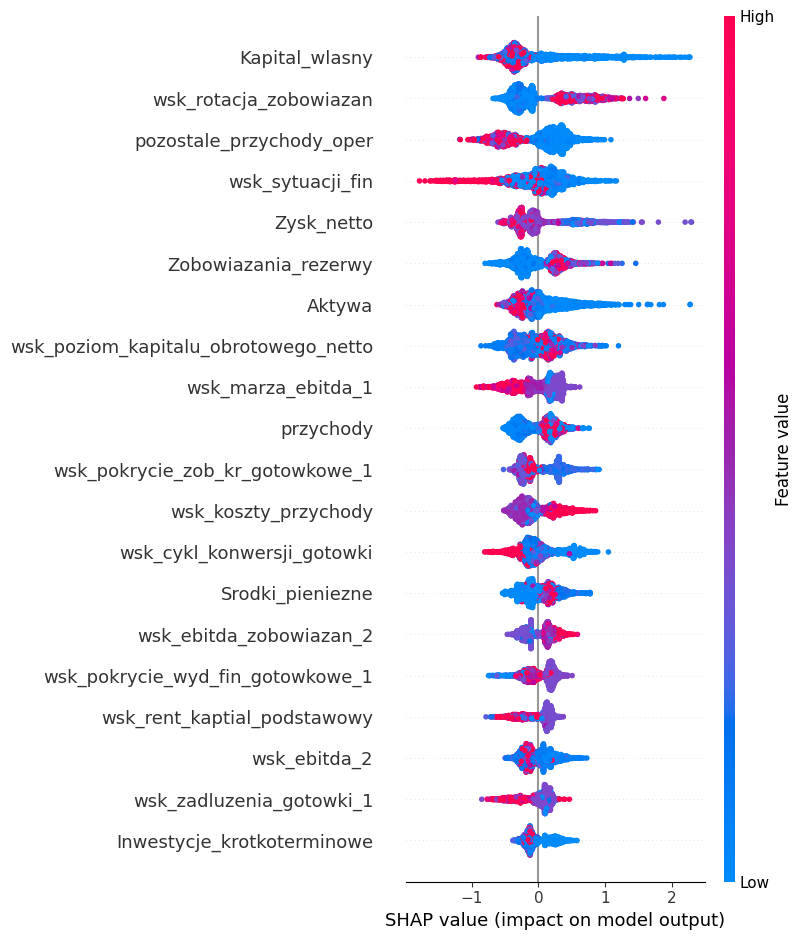

In [259]:
shap.summary_plot(shap_values, X_train)

Za pomocą następującej funkcji możemy wizualizować ważności cech w modelu za pomocą wykresu słupkowego. Ważność cechy jest mierzona na podstawie wartości SHAP dla tej cechy w całym zbiorze danych. Średnio największy wpływ miała cecha `Kapital_wlasny`, podobnie jak dla modelu interpretowalnego (tam miała drugi największy wpływ). Znaczące były również zmienne `wsk_rotacja_zobowiazan` i `pozostale_przychody_oper`.

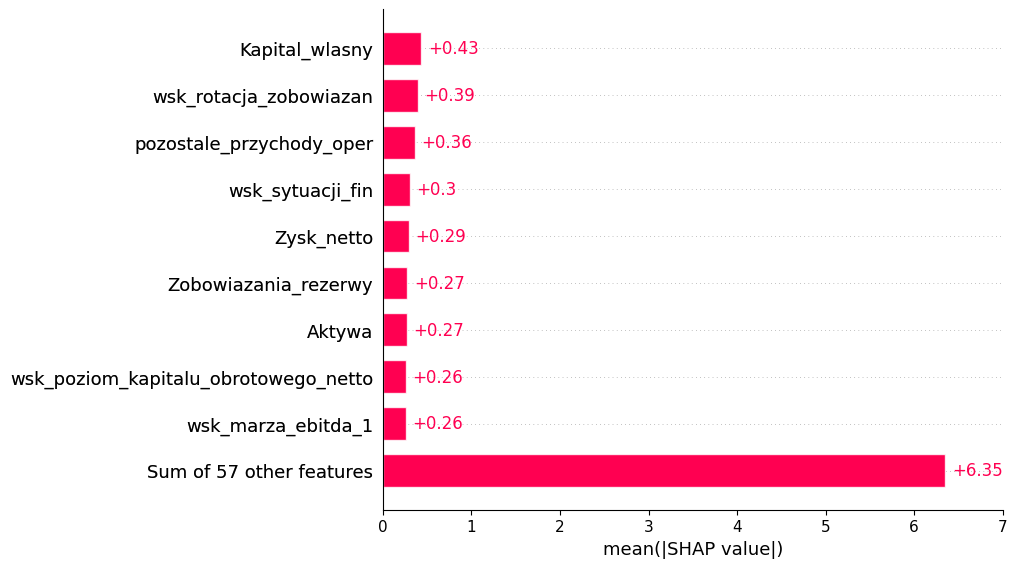

In [260]:
shap.plots.bar(shap_values)

Na następującym wykresie pokazane są maksymalne wartości SHAP dla każdej zmiennej. Największą wartość maksymalną miała zmienna `Zysk_netto`, a po niej zmienne `Aktywa` i `Kapital_wlasny`. Zmienne te miały również wysoką średnią wartość SHAP, co widać na poprzednim wykresie, więc można wyciągnąć wniosek, że są bardzo wpływowe na wyniki przewidywania klasyfikatora.

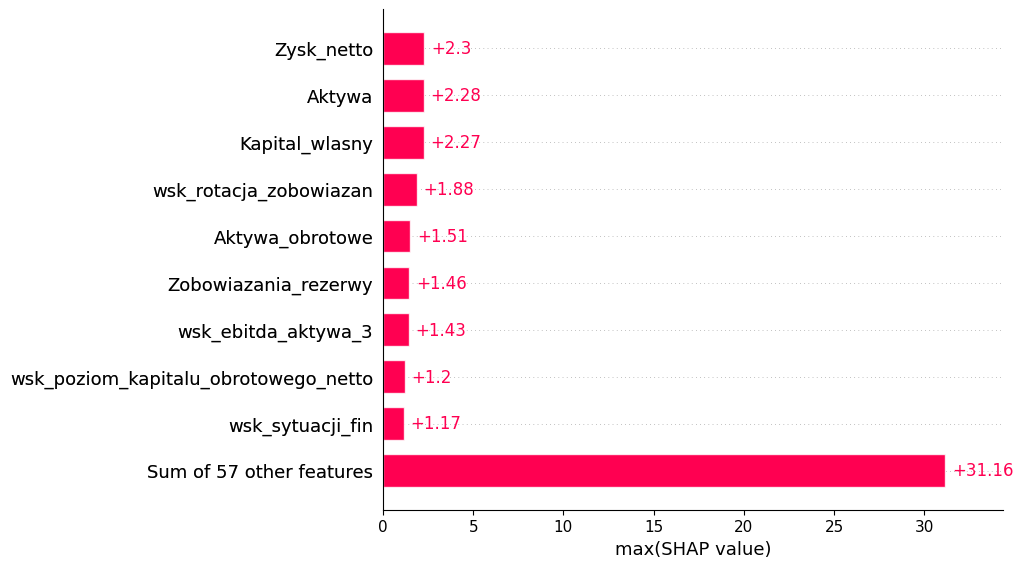

In [261]:
shap.plots.bar(shap_values.max(axis=0))

Zbadaliśmy również wartości SHAP dla poszczególnych próbek. Wyniki widać na wykresach poniżej. Przedstawiają one wpływ poszczególnych zmiennych na predykcję klasyfikatora. Wu próbkach największą wagę miała zmienna `wsk_rotacja_zobowiazan`. W pierwszej próbce klasyfikator zwrócił uwagę również na zmienną `Kapital_wlasny`, lecz w drugiej próbce ma ona już znacznie mniejszą wagę. Odwrotnie jest ze zmienną `pozostale_przychody_oper`, która odgrywa bardzo dużą rolę w drugiej próbce, natomiast w pierwszej jest ona mniej ważna.

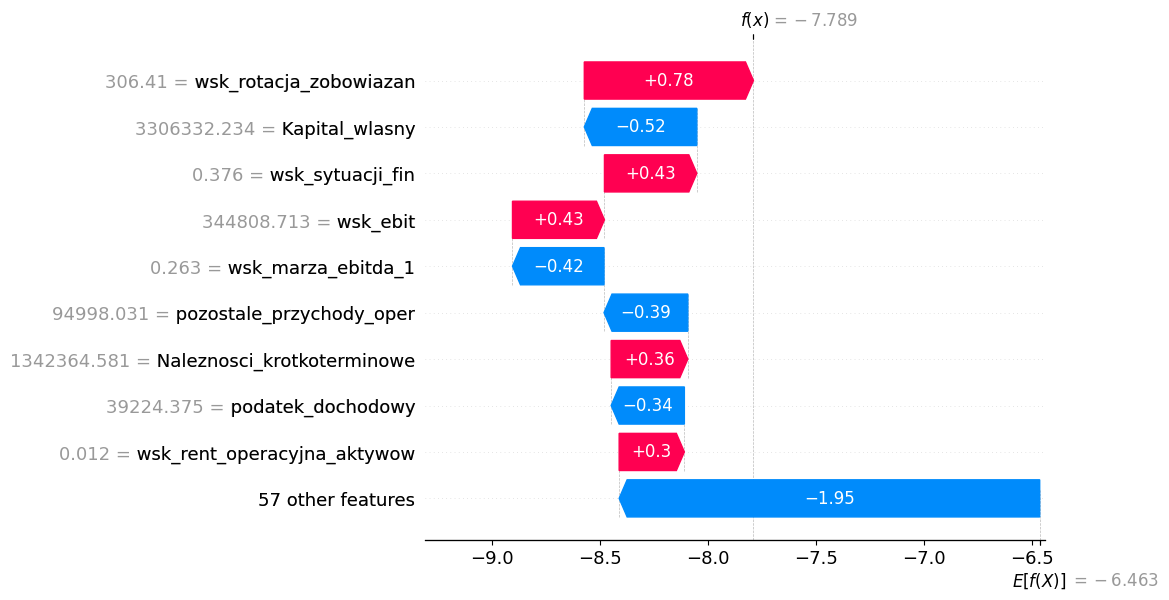

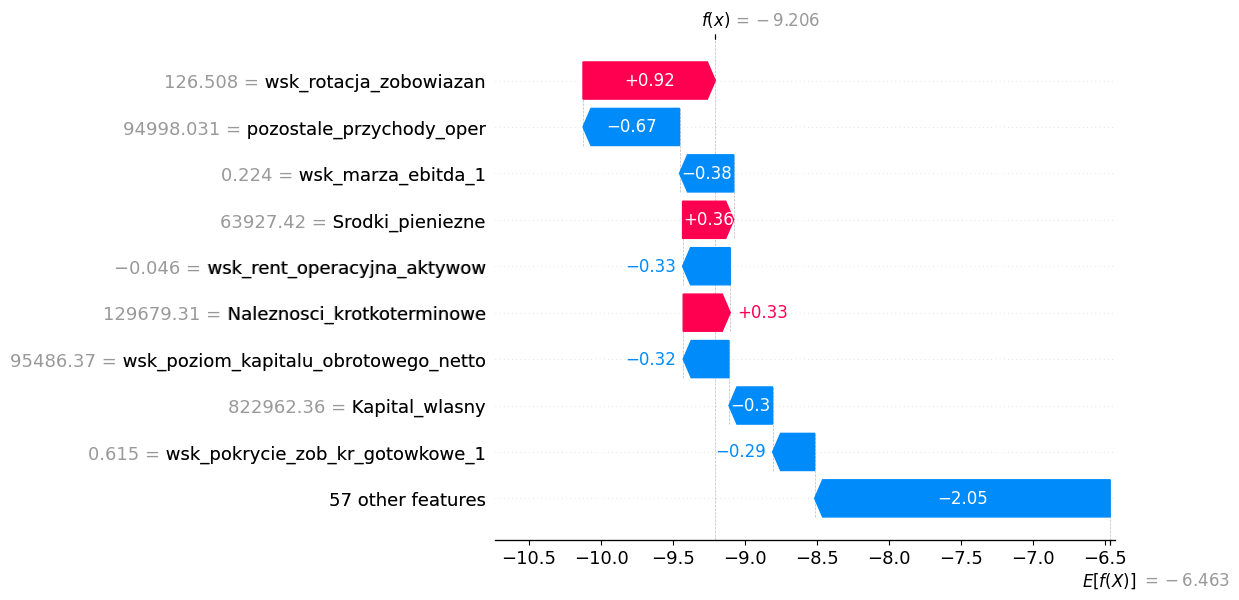

In [262]:
shap.plots.waterfall(shap_values[0])
shap.plots.waterfall(shap_values[1])